<a href="https://colab.research.google.com/github/AlrikF/Data_Science/blob/main/Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks/Data\ Science
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Data Science
datasets  Housing.ipynb


In [84]:
import os 
import tarfile 
from six.moves import urllib 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/" 
HOUSING_PATH = os.path.join("datasets", "housing") 
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz" 
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH): 
    if not os.path.isdir(housing_path): 
        os.makedirs(housing_path) 
    tgz_path = os.path.join(housing_path, "housing.tgz") 
    urllib.request.urlretrieve(housing_url, tgz_path) 
    housing_tgz = tarfile.open(tgz_path) 
    housing_tgz.extractall(path=housing_path) 
    housing_tgz.close()



In [85]:

def load_housing_data(housing_path=HOUSING_PATH): 
    csv_path = os.path.join(housing_path, "housing.csv") 
    return pd.read_csv(csv_path)


In [86]:
fetch_housing_data()
housing = load_housing_data()


In [87]:
print(housing.head())
print(housing.describe())
print(housing.info())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
          longitude      latitude  housing_median_age   total_rooms  \
coun

In [88]:
housing["ocean_proximity"].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

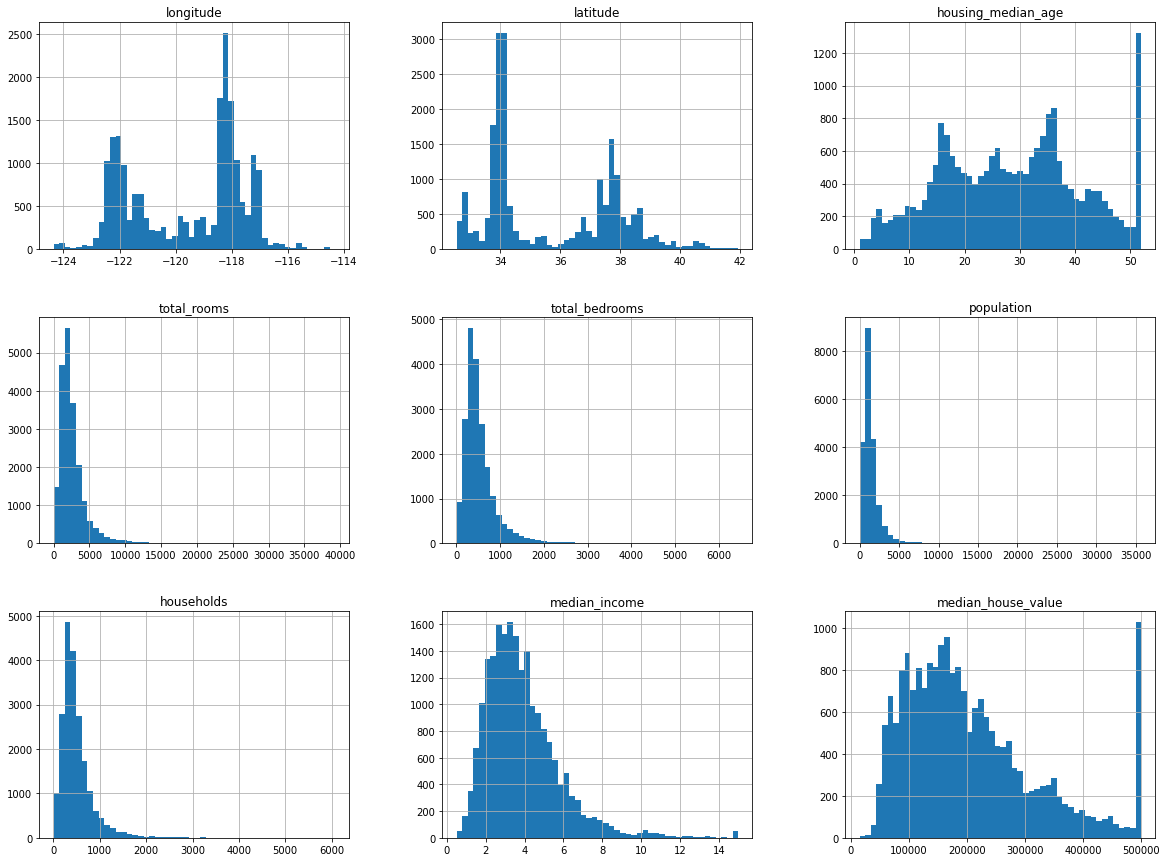

In [89]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()


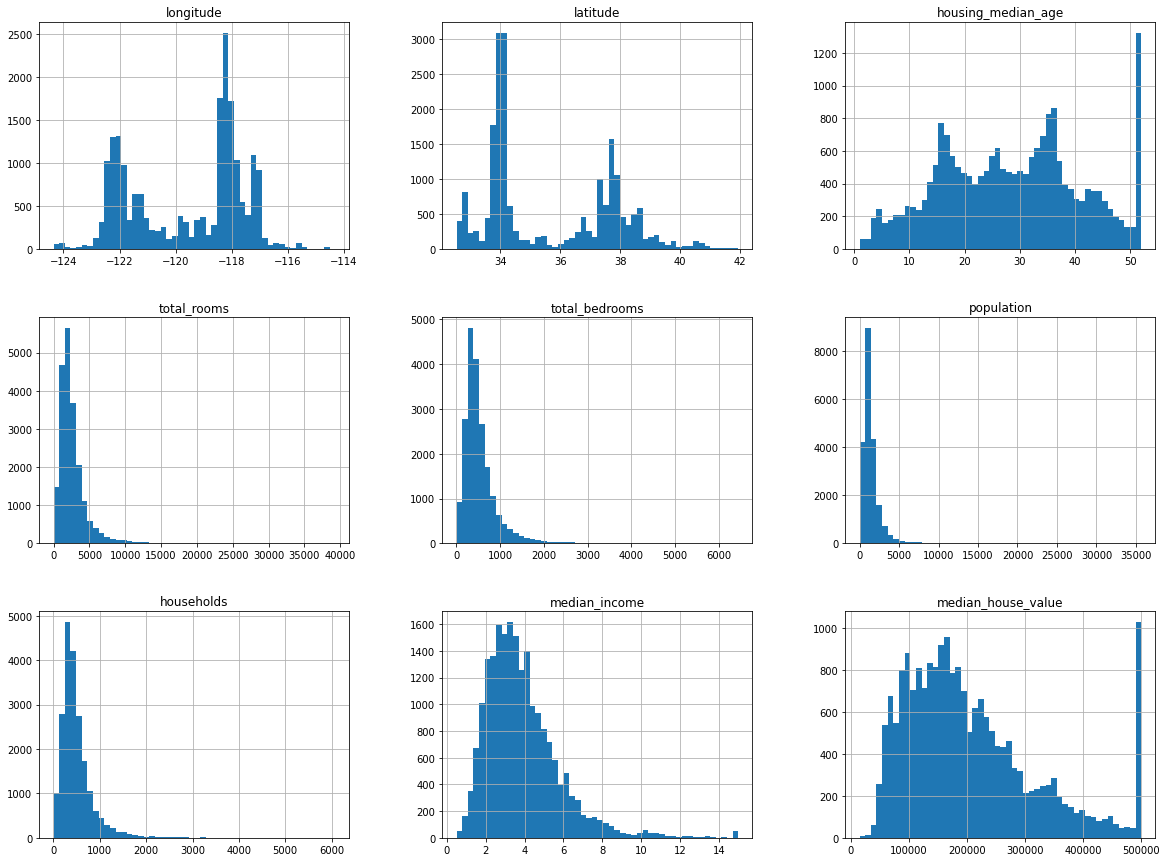

In [90]:

housing.hist(bins=50, figsize=(20,15))
plt.show()


In [91]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [92]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))

print(len(test_set))


16512
4128


One solution is to save the test set on the first run and then load it in subsequent
runs. Another option is to set the random number generator’s seed (e.g., np.ran
dom.seed(42))
14 before calling np.random.permutation(), so that it always generates
the same shuffled indices.
But both these solutions will break next time you fetch an updated dataset. A com‐
mon solution is to use each instance’s identifier to decide whether or not it should go
in the test set (assuming instances have a unique and immutable identifier). For
example, you could compute a hash of each instance’s identifier and put that instance
in the test set if the hash is lower or equal to 20% of the maximum hash value. This
ensures that the test set will remain consistent across multiple runs, even if you
refresh the dataset. The new test set will contain 20% of the new instances, but it will
not contain any instance that was previously in the training set. Here is a possible
implementation:

In [93]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]



In [94]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")




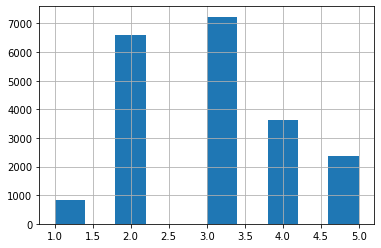

In [95]:
#Coverting continuous to categorical (stratified data with enough samples in order to ensure stratified sampling)
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist()


In [96]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [97]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)


3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [98]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


In [99]:
housing = strat_train_set.copy()


Setting the alpha option to 0.1 makes it much easier to visualize the places
where there is a high density of data points


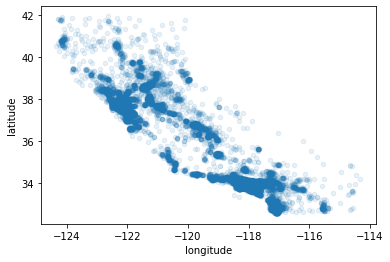

In [100]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


The radius of each circle represents
the district’s population (option s), and the color represents the price (option c). We
will use a predefined color map (option cmap) called jet, which ranges from blue
(low values) to red (high prices)


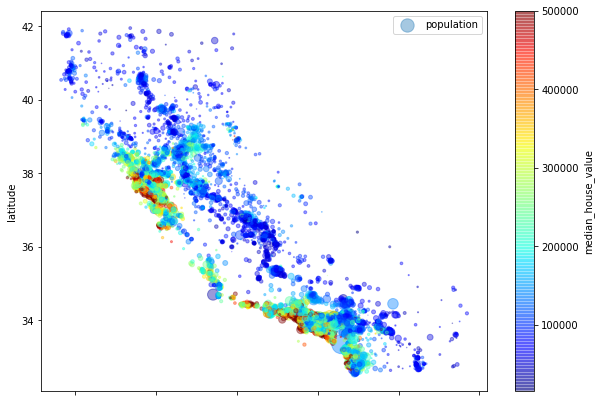

In [101]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96e8982610>,
      dtype=object)

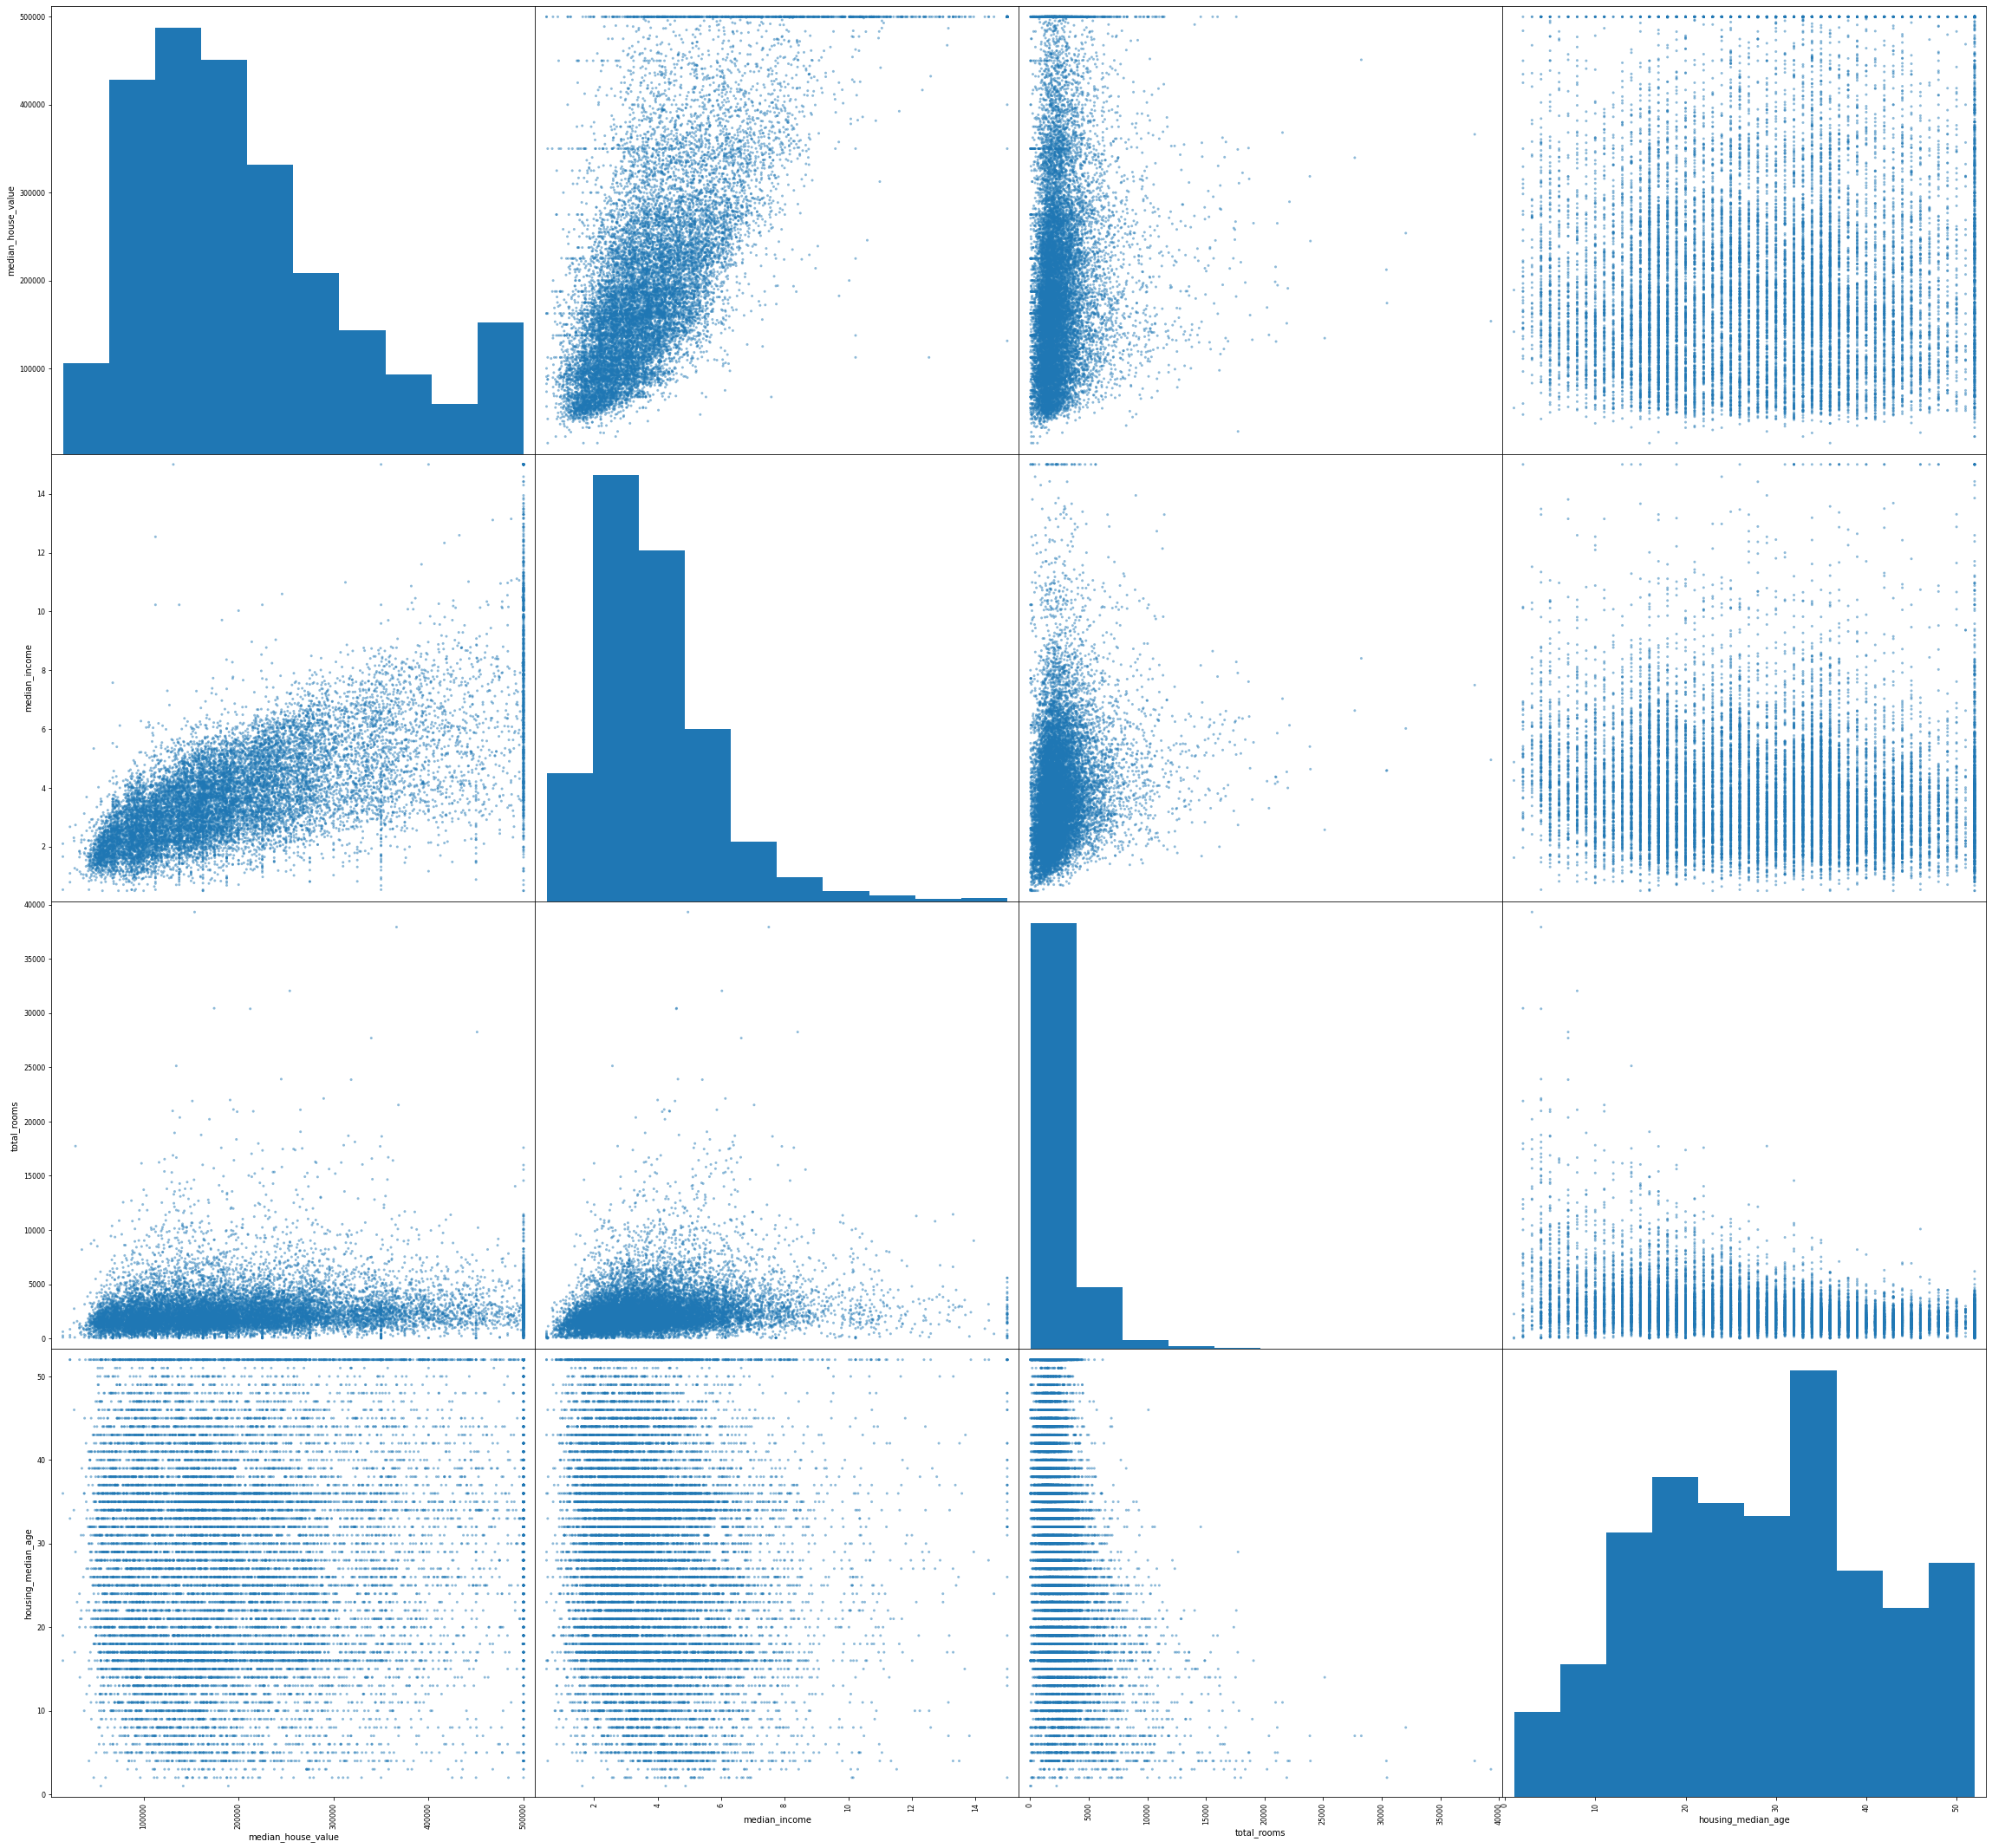

In [102]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(40, 38))


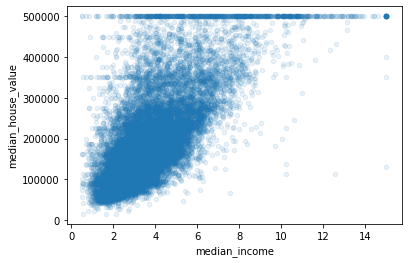

In [103]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)


In [104]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]


In [105]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [106]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


In [107]:
housing.dropna(subset=["total_bedrooms"]) # option 1
housing.drop("total_bedrooms", axis=1) # option 2
median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)


In [108]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)


In [109]:
from sklearn.preprocessing import OrdinalEncoder

housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:10])
ordinal_encoder.categories_




[[1.]
 [4.]
 [1.]
 [4.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]]


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [110]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot




<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [111]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [112]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('attribs_adder', CombinedAttributesAdder()), ('std_scaler', StandardScaler()), ])
housing_num_tr = num_pipeline.fit_transform(housing_num)



In [113]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", OneHotEncoder(), cat_attribs),])
housing_prepared = full_pipeline.fit_transform(housing)


Linear Regression 

In [114]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))


Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [115]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


68627.87390018745

Decision Trees  

In [116]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse


0.0

In [117]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)


In [118]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)


Scores: [72980.50606273 69893.66627    66368.29663953 72494.16270854
 68732.66141395 76938.35966025 71832.24785077 72751.28457746
 69415.30869838 69468.88325747]
Mean: 71087.5377139096
Standard deviation: 2788.8185162784143


In [119]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)




Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180644


Random Forest 

In [120]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)




Scores: [51585.18620668 49215.86070689 46786.52889951 52355.99318167
 46974.18390679 51896.79239516 52660.08512646 50084.92097194
 48947.91622824 53555.5216557 ]
Mean: 50406.29892790605
Standard deviation: 2256.972869068675


In [121]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_

grid_search.best_estimator_



RandomForestRegressor(max_features=6, n_estimators=30)

In [122]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


64875.328886016876 {'max_features': 2, 'n_estimators': 3}
55275.09443651274 {'max_features': 2, 'n_estimators': 10}
52839.92391957256 {'max_features': 2, 'n_estimators': 30}
59419.196214142365 {'max_features': 4, 'n_estimators': 3}
52990.7140055512 {'max_features': 4, 'n_estimators': 10}
50530.969062794444 {'max_features': 4, 'n_estimators': 30}
59596.87104511427 {'max_features': 6, 'n_estimators': 3}
52098.65392190447 {'max_features': 6, 'n_estimators': 10}
50112.255748545205 {'max_features': 6, 'n_estimators': 30}
58854.197287701594 {'max_features': 8, 'n_estimators': 3}
52300.3403583476 {'max_features': 8, 'n_estimators': 10}
50485.78171211585 {'max_features': 8, 'n_estimators': 30}
62365.73774683524 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54378.1765772698 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59833.69327721619 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52405.46117401668 {'bootstrap': False, 'max_features': 3, 'n_estimators': 